<a href="https://colab.research.google.com/github/sruthikoyya/SummerIntership_NITR/blob/main/modelon_cifar100_NITR_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Model, Input
from tensorflow.keras.datasets import cifar100
import numpy as np

In [2]:
# Load and preprocess MNIST dataset
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
len(X_train),len(X_test)

(50000, 10000)

In [4]:
# Normalize and convert to float32
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [5]:
#Not required because the images size is 32x32 and the images are RGB images
"""#Data Preprocessing
X_train = tf.image.resize_with_pad(tf.expand_dims(X_train, -1), 32, 32)
X_test = tf.image.resize_with_pad(tf.expand_dims(X_test, -1), 32, 32)
X_train = tf.image.grayscale_to_rgb(X_train)
X_test = tf.image.grayscale_to_rgb(X_test)"""

'#Data Preprocessing\nX_train = tf.image.resize_with_pad(tf.expand_dims(X_train, -1), 32, 32)\nX_test = tf.image.resize_with_pad(tf.expand_dims(X_test, -1), 32, 32)\nX_train = tf.image.grayscale_to_rgb(X_train)\nX_test = tf.image.grayscale_to_rgb(X_test)'

In [6]:
from tensorflow.keras.layers import BatchNormalization

In [7]:
from tensorflow.keras import layers

def dcb_block(input_tensor):
    # Dilated conv with d=1
    d1 = layers.DepthwiseConv2D(kernel_size=3, dilation_rate=1, padding='same')(input_tensor)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Conv2D(32, kernel_size=1, padding='same', activation='relu')(d1)

    # Dilated conv with d=3
    d3 = layers.DepthwiseConv2D(kernel_size=3, dilation_rate=3, padding='same')(input_tensor)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Conv2D(32, kernel_size=1, padding='same', activation='relu')(d3)

    # Concatenate d1 and d3
    concat_13 = layers.Concatenate()([d1, d3])
    concat_13 = layers.BatchNormalization()(concat_13)
    concat_13 = layers.Conv2D(32, kernel_size=1, padding='same', activation='relu')(concat_13)

    # Multiply concat_13 and d3
    multiplied = layers.Multiply()([concat_13, d3])
    multiplied = layers.BatchNormalization()(multiplied)
    multiplied = layers.Conv2D(32, kernel_size=1, padding='same', activation='relu')(multiplied)

    # Apply sigmoid to multiplied
    mul_sigmoid = layers.Activation('sigmoid')(multiplied)

    # Dilated conv with d=5
    d5 = layers.DepthwiseConv2D(kernel_size=3, dilation_rate=5, padding='same')(input_tensor)
    d5 = layers.BatchNormalization()(d5)
    d5 = layers.Conv2D(32, kernel_size=1, padding='same', activation='relu')(d5)

    # Concatenate mul_sigmoid and d5
    refined = layers.Concatenate()([mul_sigmoid, d5])

    return refined


In [8]:
from tensorflow.keras import backend as K

def cbam_block(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    # Channel Attention
    shared_dense = Sequential([
        layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True),
        layers.Dense(channel, kernel_initializer='he_normal', use_bias=True)
    ])

    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    max_pool = layers.GlobalMaxPooling2D()(input_feature)

    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)

    avg_out = shared_dense(avg_pool)
    max_out = shared_dense(max_pool)

    channel_attention = layers.Activation('sigmoid')(avg_out + max_out)
    channel_refined = layers.Multiply()([input_feature, channel_attention])

    # Spatial Attention
    avg_pool = layers.Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(channel_refined)
    max_pool = layers.Lambda(lambda x: K.max(x, axis=3, keepdims=True))(channel_refined)
    spatial_attention = layers.Concatenate(axis=3)([avg_pool, max_pool])
    spatial_attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(spatial_attention)

    refined_feature = layers.Multiply()([channel_refined, spatial_attention])
    return refined_feature


In [9]:
# Build the full model
def build_model():
    inputs = Input(shape=(32, 32, 3))

    # Pretrained ResNet50
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3), pooling='avg')
    base_model.trainable = False

    x = base_model(inputs)
    x = layers.Reshape((1, 1, 2048))(x)
    x = layers.Conv2D(128, kernel_size=1, padding='same')(x)
    x = layers.UpSampling2D(size=(4, 4))(x)  # optional resizing to give spatial dimensions

    x = dcb_block(x)
    x = cbam_block(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(100, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [ ]:
# Instantiate and compile the model
model = build_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model and store training history
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 294s 196ms/step - accuracy: 0.0471 - loss: 4.3506 - val_accuracy: 0.0408 - val_loss: 5.2707
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 275s 195ms/step - accuracy: 0.1109 - loss: 3.8821 - val_accuracy: 0.0292 - val_loss: 7.3155
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 328s 199ms/step - accuracy: 0.1410 - loss: 3.6829 - val_accuracy: 0.0446 - val_loss: 6.3481
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 290s 177ms/step - accuracy: 0.1566 - loss: 3.5809 - val_accuracy: 0.0380 - val_loss: 6.1386
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 269s 191ms/step - accuracy: 0.1713 - loss: 3.5148 - val_accuracy: 0.0444 - val_loss: 5.9439
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 256s 182ms/step - accuracy: 0.1798 - loss: 3.4623 - val_accuracy: 0.0446 - val_loss: 5.8346
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 287s 200ms/step - accuracy: 0.1917 - loss: 3.4040 - val_accuracy: 0.0510 - val_loss: 6.3157
Epoch 8/50


In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


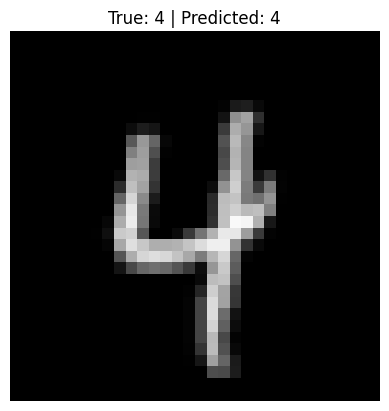

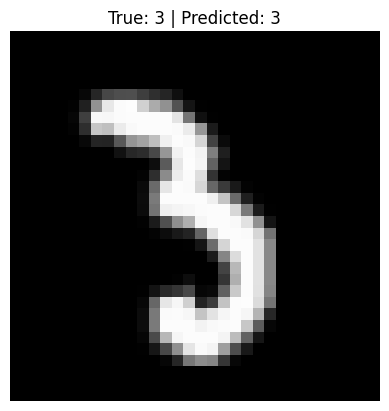

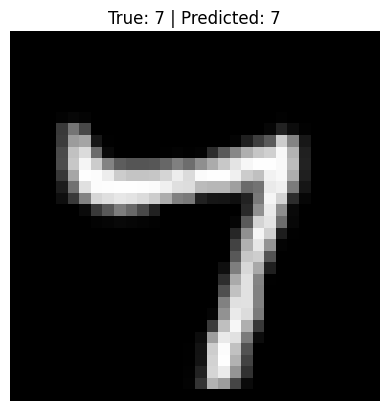

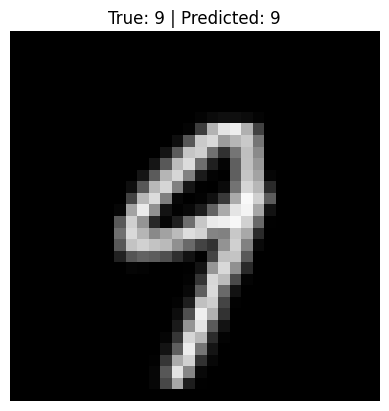

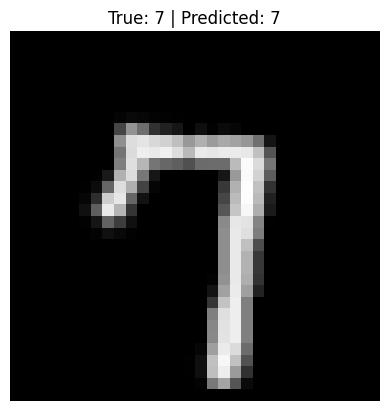

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert only X_test to numpy if it's a tensor
if isinstance(X_test, tf.Tensor):
    X_test_np = X_test.numpy()
else:
    X_test_np = X_test

# y_test is already a NumPy array
y_test_np = y_test

# Pick 5 random test samples
num_samples = 5
indices = np.random.choice(len(X_test_np), num_samples, replace=False)
sample_images = X_test_np[indices]
sample_labels = y_test_np[indices]

# Get predictions
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display each sample
for i in range(num_samples):
    plt.imshow(sample_images[i])
    plt.title(f"True: {sample_labels[i]} | Predicted: {predicted_classes[i]}")
    plt.axis('off')
    plt.show()
